In [1]:
import janitor
import pandas
import geopandas
from path import Path
import os
import numpy
import sys
import re
from functools import reduce
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [108]:
import seaborn as sns

In [2]:
from utils import _geo_merge

In [3]:
# path configuration
working_directory = Path.getcwd()

inputs_path = working_directory / 'inputs'
outputs_path = working_directory / 'outputs'

In [4]:
# export function
def to_file(callback, desired_name, extension='csv'):
    current_files = sorted(outputs_path.files(desired_name + '*.' + extension))
    if current_files:
        last_file = current_files[-1]
        os.remove(last_file)
    final_name = '{}.{}'.format(desired_name, extension)
    callback(outputs_path / final_name)

In [16]:
# path to csv dataframe
df_path = inputs_path / '1541905_MoDotIntersections_TopRoutes_OD_Covered/1541905_MoDotIntersections_TopRoutes_OD_Covered/1541905_MoDotIntersections_TopRoutes_OD_Covered_tr_od.csv'


# path to geodataframes
dest_path = inputs_path / '1541905_MoDotIntersections_TopRoutes_OD_Covered/Shapefile/1541905_MoDotIntersections_TopRoutes_OD_Covered_destination/1541905_MoDotIntersections_TopRoutes_OD_Covered_destination.shp'
dest_line_path = inputs_path / '1541905_MoDotIntersections_TopRoutes_OD_Covered/Shapefile/1541905_MoDotIntersections_TopRoutes_OD_Covered_destination_line/1541905_MoDotIntersections_TopRoutes_OD_Covered_destination_line.shp'
org_path = inputs_path / '1541905_MoDotIntersections_TopRoutes_OD_Covered/Shapefile/1541905_MoDotIntersections_TopRoutes_OD_Covered_origin/1541905_MoDotIntersections_TopRoutes_OD_Covered_origin.shp'
org_line_path = inputs_path / '1541905_MoDotIntersections_TopRoutes_OD_Covered/Shapefile/1541905_MoDotIntersections_TopRoutes_OD_Covered_osm_segment/1541905_MoDotIntersections_TopRoutes_OD_Covered_osm_segment.shp'
seg_path = inputs_path / '1541905_MoDotIntersections_TopRoutes_OD_Covered/Shapefile/1541905_MoDotIntersections_TopRoutes_OD_Covered_osm_segment/1541905_MoDotIntersections_TopRoutes_OD_Covered_osm_segment.shp'

In [38]:
# restore mo_places and zone_points
%store -r mo_places

In [ ]:
# read in files

df = pandas.read_csv(df_path).clean_names()

# read in geos
geo_dest = geopandas.read_file(dest_path)

geo_dest_line = geopandas.read_file(dest_line_path)

geo_seg = geopandas.read_file(seg_path)

geo_org = geopandas.read_file(org_path)

geo_org_line = geopandas.read_file(org_line_path)

In [59]:
# drop unneeded row values

df = df[df.origin_zone_name!='South First Street / 719359682 / 1']

,mode_of_travel,vehicle_weight,origin_zone_id,origin_zone_name,origin_zone_is_pass_through,origin_zone_direction_degrees_,origin_zone_is_bi_direction,segment_id,segment_name,segment_type,...,destination_zone_is_pass_through,destination_zone_direction_degrees_,destination_zone_is_bi_direction,day_type,day_part,average_daily_o_s_d_traffic_stl_volume_,average_daily_o_d_traffic_stl_volume_,average_daily_origin_zone_traffic_stl_volume_,average_daily_destination_zone_traffic_stl_volume_,trip_proportion
0,All Vehicles LBS Plus - StL All Vehicles Volume,All,4607888.0,A4607888,yes,36,yes,1000524819,Jackson Street / 18391192 / 1,Residential,...,yes,52,yes,0: All Days (M-Su),0: All Day (12am-12am),0.0,20,7542,910,0.013
1,All Vehicles LBS Plus - StL All Vehicles Volume,All,4607888.0,A4607888,yes,36,yes,1000672789,East Myrtle Street / 18389242 / 2,Residential,...,yes,52,yes,0: All Days (M-Su),0: All Day (12am-12am),1.0,20,7542,910,0.026
2,All Vehicles LBS Plus - StL All Vehicles Volume,All,4607888.0,A4607888,yes,36,yes,1003373146,South Walnut Street / 18388744 / 1,Residential,...,yes,52,yes,0: All Days (M-Su),0: All Day (12am-12am),0.0,20,7542,910,0.016
3,All Vehicles LBS Plus - StL All Vehicles Volume,All,4607888.0,A4607888,yes,36,yes,1005674765,South Randolph Street / 18392888 / 2,Residential,...,yes,52,yes,0: All Days (M-Su),0: All Day (12am-12am),0.0,20,7542,910,0.016
4,All Vehicles LBS Plus - StL All Vehicles Volume,All,4607888.0,A4607888,yes,36,yes,1005695670,East Myrtle Street / 18389242 / 3,Residential,...,yes,52,yes,0: All Days (M-Su),0: All Day (12am-12am),0.0,20,7542,910,0.013


(49872, 22)

<Axes: >

<Axes: >

<Axes: >

<Axes: >

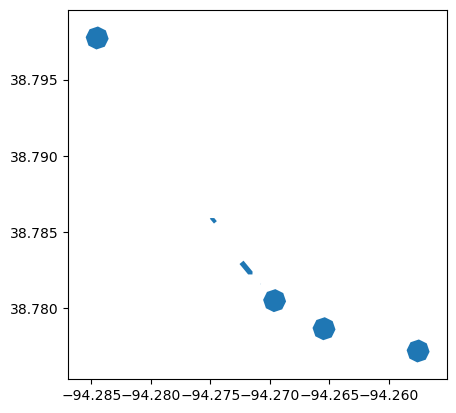

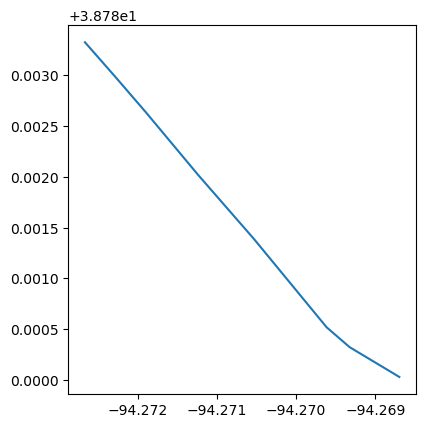

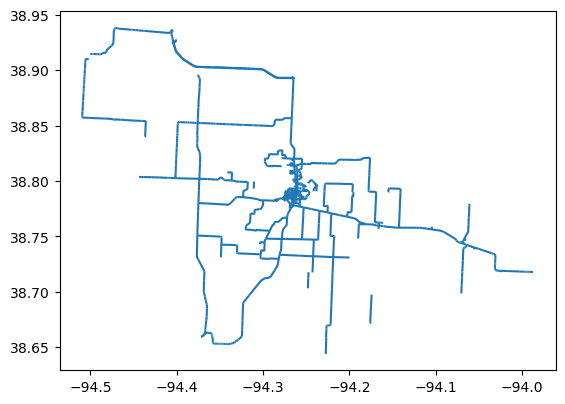

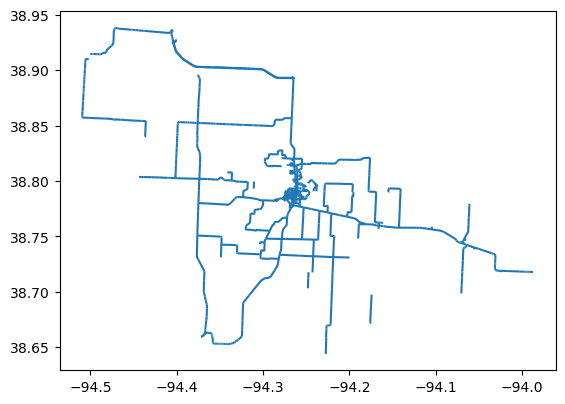

In [26]:
# view dataframe
display(
    df.head(),
    df.shape
)

# view geodataframes
display(
    geo_dest.plot(),
    geo_dest_line.plot(),
    geo_seg.plot(),
    geo_org_line.plot()
)

In [35]:
# get overview of data
summary_df = pandas.DataFrame(
    [
        [df[column].dtypes, df[column].nunique(), df[column].isna().sum()]
        for column in df.columns
    ],
    index=df.columns,
    columns=['type_', 'nunique', 'nempty']
)
summary_df

,type_,nunique,nempty
mode_of_travel,object,1,0
vehicle_weight,object,1,0
origin_zone_id,float64,6,3762
origin_zone_name,object,7,0
origin_zone_is_pass_through,object,1,0
origin_zone_direction_degrees_,int64,7,0
origin_zone_is_bi_direction,object,1,0
segment_id,int64,1015,0
segment_name,object,1015,0
segment_type,object,6,0


### Merge Data

In [113]:
merged_pnts = geo_dest.merge(df, left_on='name',right_on='origin_zone_name').set_index('name')

In [122]:
geo_seg

,segment_id,name,segment_ty,geometry
0,1.000198e+09,Cantrell Road / 525069457 / 1,primary,"LINESTRING (-94.36916 38.66050, -94.36939 38.6..."
1,1.000230e+09,residential / 18539727 / 1,residential,"LINESTRING (-94.06765 38.74710, -94.06614 38.7..."
2,1.000401e+09,Sugarland Drive / 67137927 / 5,residential,"LINESTRING (-94.26944 38.81442, -94.27011 38.8..."
3,1.000514e+09,Cantrell Road / 470108962 / 3,residential,"LINESTRING (-94.36969 38.66030, -94.36962 38.6..."
4,1.000525e+09,Jackson Street / 18391192 / 1,residential,"LINESTRING (-94.26654 38.78158, -94.26547 38.7..."
...,...,...,...,...
1010,1.109605e+09,State Highway 58 / 525291228 / 6,secondary,"LINESTRING (-94.23459 38.77322, -94.23366 38.7..."
1011,1.109607e+09,SW State Highway West / 18554217 / 3,residential,"LINESTRING (-94.06200 38.76100, -94.06190 38.7..."
1012,1.109626e+09,East 199th Street / 18393734 / 1,residential,"LINESTRING (-94.31980 38.75621, -94.31974 38.7..."
1013,1.109635e+09,Horridge Road / 18524885 / 3,residential,"LINESTRING (-94.43570 38.85418, -94.43577 38.8..."


### Look by direciton, traffic volumes

In [72]:
quant_variables = ['average_daily_o_s_d_traffic_stl_volume_','average_daily_o_d_traffic_stl_volume_','average_daily_origin_zone_traffic_stl_volume_','average_daily_destination_zone_traffic_stl_volume_','trip_proportion']

### Compare to information from original points

In [ ]:
# density distribution by zone

In [78]:
merged_pnts.origin_zone_id.unique()

array([4607888., 4933881., 5105323., 5190933., 5190939., 5190956.])

In [80]:
od_day_part = merged_pnts.groupby(['origin_zone_id','destination_zone_id','day_part'])[quant_variables].mean()

In [83]:
od = merged_pnts.groupby(['origin_zone_id','destination_zone_id'])[quant_variables].mean()

In [ ]:
merged_pnts[(merged_pnts[state1] == 1) & (merged_pnts[state2] == 1)]

### Look at some spatial models

In [119]:
merged_pnts['latitude'] = merged_pnts.geometry.y
merged_pnts['longitude'] = merged_pnts.geometry.x

sns.kdeplot(merged_pnts['longitude'], merged_pnts['latitude'], shade=True, cmap='viridis');

ValueError: y attribute access only provided for Point geometries

In [ ]:
to_file(merged_pnts)

In [ ]:
# Set choropleth basemap
basemap = mo_places.plot(column = "ALAND", cmap = "YlGnBu")

# Plot transparent proportional symbols on top of basemap
geo_state_pt.plot(ax = basemap, markersize = (numpy.sqrt(merged["total_revenue"])), color = "lightgray", edgecolor = "darkgray", alpha = 0.7,legend = True, legend_kwds={"fmt": "{:.0f}"},scheme='natural_breaks', k=4)

plt.title('Fig E-1: Revenue (Points) by Average Years as Customer and State')
plt.axis('off')
plt.show();

,id,name,direction,is_pass,is_bidi,geometry
0,4607888,A4607888,36.000,1,1,"POLYGON ((-94.26448 38.77861, -94.26480 38.778..."
1,4933881,A4933881,52.000,1,1,"POLYGON ((-94.27470 38.78556, -94.27504 38.785..."
2,5105323,A5105323,311.000,1,1,"POLYGON ((-94.27146 38.78222, -94.27182 38.782..."
3,5190933,A5190933,97.000,1,1,"POLYGON ((-94.28355 38.79767, -94.28388 38.797..."
4,5190939,A5190939,360.000,1,1,"POLYGON ((-94.25656 38.77715, -94.25689 38.776..."
5,5190956,A5190956,124.000,1,1,"POLYGON ((-94.26863 38.78045, -94.26896 38.779..."
6,N/A,South First Street / 719359682 / 1,138.934,1,1,"POLYGON ((-94.27075 38.78162, -94.27074 38.781..."
